In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
work_directory="/content/drive/MyDrive/Plant_Diseases"

In [ ]:
cd /content/drive/MyDrive/Plant_Diseases

/content/drive/MyDrive/Plant_Diseases


In [ ]:
!mkdir "output"

mkdir: cannot create directory ‘output’: File exists


In [ ]:
!mkdir "output/transformer"

mkdir: cannot create directory ‘output/transformer’: File exists


**<h2> 1. Import the necessary libraries </h2>**

In [ ]:
!pip install tensorflow_addons
!pip install vit_keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau, CSVLogger


from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D,BatchNormalization, Conv2D,
                                     MaxPooling2D, Dropout, Flatten, Activation)


from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (precision_recall_curve, accuracy_score, f1_score, confusion_matrix,
                             precision_score, recall_score, classification_report)
from sklearn.preprocessing import LabelEncoder

# used to supress display of warnings
import warnings

import pickle
import numpy as np
import glob
import cv2
import h5py
import os
import json
import datetime
import time
import sys
import argparse
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.image import imread
import seaborn as sns

%matplotlib inline

In [ ]:

import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

TensorFlow Version 2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# suppress display of warnings
warnings.filterwarnings('ignore')

**<h2> 2. Read Data </h2>**


In [ ]:
cd /content

/content


In [ ]:
!gdown --id 1iwSqkNwCc2x13zMixfsSQRYGc5G2kBiH

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1iwSqkNwCc2x13zMixfsSQRYGc5G2kBiH
From (redirected): https://drive.google.com/uc?id=1iwSqkNwCc2x13zMixfsSQRYGc5G2kBiH&confirm=t&uuid=17c11ee6-6539-4df3-8374-b42d4e31c371
To: /content/archive.zip
100% 2.90G/2.90G [00:51<00:00, 56.7MB/s]


In [ ]:
!unzip /content/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [ ]:
data_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
test_dir = data_dir + "/valid"

In [ ]:
disease_classes = os.listdir(train_dir)
nb_in_diseases = {}
for d_class in disease_classes:
    nb_in_diseases[d_class] = len(os.listdir(train_dir + '/' + d_class))

train_data = pd.DataFrame(list(zip(nb_in_diseases.keys(),nb_in_diseases.values())), columns=["Desease", "no. of images"])
train_data.shape

(38, 2)

**Data Geneerator**

In [ ]:
train_dir = data_dir + "/train"
test_dir = data_dir + "/valid"

In [ ]:
CATEGORIES = [ 'Tomato___Early_blight', 'Tomato___Leaf_Mold', 'Tomato___Bacterial_spot',
 'Tomato___Late_blight','Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus',
 'Tomato___Septoria_leaf_spot','Tomato___healthy','Tomato___Spider_mites Two-spotted_spider_mite']

In [ ]:
plant='tomato'

In [ ]:
generator= ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255.0,
    fill_mode='nearest',
    validation_split=0.1)


test_generator= ImageDataGenerator(
    rescale=1/255.0)


train_gen = generator.flow_from_directory(train_dir,
                                          batch_size=32,
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          subset='training',
                                          classes=CATEGORIES,
                                          seed=42)
valid_gen = generator.flow_from_directory(train_dir,
                                          batch_size=128,
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          subset='validation',
                                          classes=CATEGORIES,
                                          seed=42)
test_gen = test_generator.flow_from_directory(test_dir,
                                              batch_size=128,
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              shuffle = False,
                                              classes=CATEGORIES,
                                              class_mode='categorical')

Found 5134 images belonging to 3 classes.
Found 568 images belonging to 3 classes.
Found 1426 images belonging to 3 classes.


**Display some train data images**

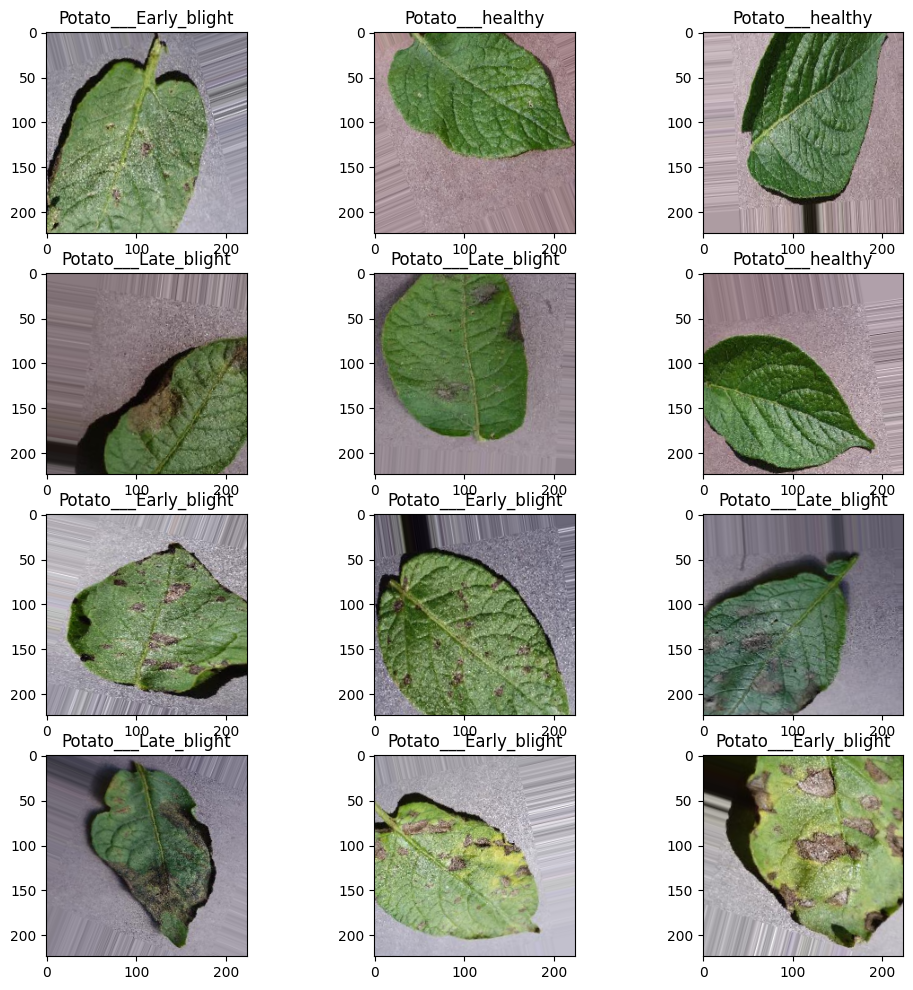

In [ ]:
classes=list(train_gen.class_indices.keys())
plt.figure(figsize=(12,12))
for X_batch, y_batch in train_gen:
    for i in range(0,12):
        plt.subplot(4,3,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    plt.show()
    break

**<h2>3. Building transformer model**

In [ ]:
from vit_keras import vit
image_size = 224
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(CATEGORIES))

347502902/347502902 [==============================] - 1s 0us/step


In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


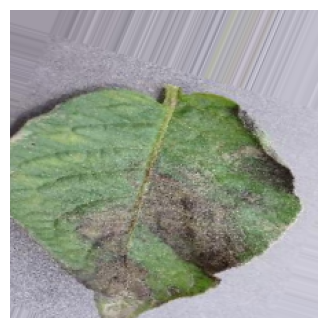

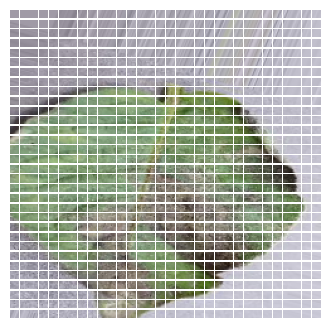

In [ ]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image)
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis('off')

In [ ]:
vit_model.summary()

Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape (Reshape)           (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [ ]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(len(CATEGORIES), 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

In [ ]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 64)         

**4. Training the model**

In [ ]:
from tensorflow import optimizers
opt = optimizers.Adam(learning_rate=0.0001)

In [ ]:
csv_logger = CSVLogger(work_directory+f"/output/transformer/history_{plant}.csv", append=True)
filepath = work_directory+f'/output/transformer/best_model_{plant}.h5'
checkpoint = ModelCheckpoint(filepath, monitor="val_loss",save_best_only=True, verbose=1)
early_stoping = EarlyStopping(monitor='loss', patience=2)
callbacks = [checkpoint, early_stoping, csv_logger]

In [ ]:
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              validation_data=valid_gen,
                              epochs = 10,
                              callbacks=callbacks,
                              )

Epoch 1/10
161/161 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9573
Epoch 1: val_loss improved from inf to 0.03758, saving model to /content/drive/MyDrive/Plant_Diseases/output/transformer/best_model_potato.h5
161/161 [==============================] - 364s 2s/step - loss: 0.1524 - accuracy: 0.9573 - val_loss: 0.0376 - val_accuracy: 0.9894
Epoch 2/10
161/161 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9936
Epoch 2: val_loss did not improve from 0.03758
161/161 [==============================] - 288s 2s/step - loss: 0.0295 - accuracy: 0.9936 - val_loss: 0.0501 - val_accuracy: 0.9859
Epoch 3/10
161/161 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9953
Epoch 3: val_loss improved from 0.03758 to 0.00730, saving model to /content/drive/MyDrive/Plant_Diseases/output/transformer/best_model_potato.h5
161/161 [==============================] - 302s 2s/step - loss: 0.0188 - accuracy: 0.9953 - val_loss: 0.0073 - va

**Plot training model performance over epochs**

In [ ]:
df = pd.read_csv(work_directory+f"/output/transformer/history_{plant}.csv")

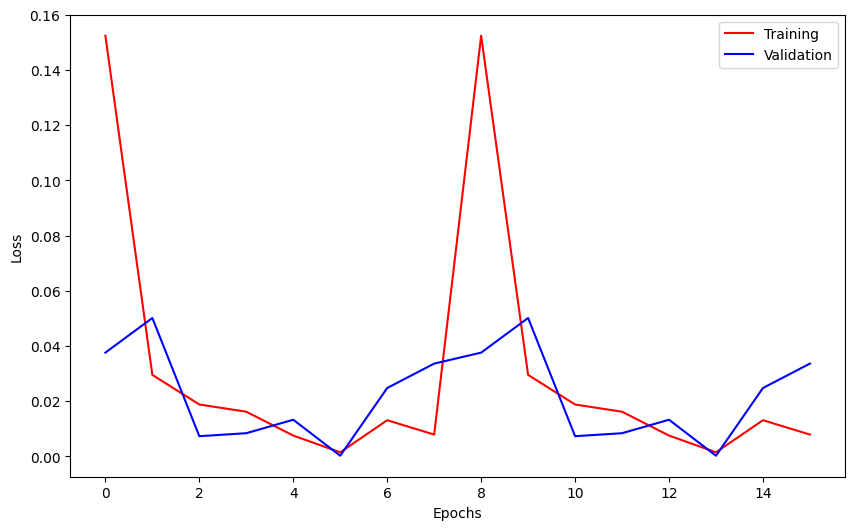

In [ ]:
loss = df.loss.values
loss_acc =df.val_loss.values
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,loss_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

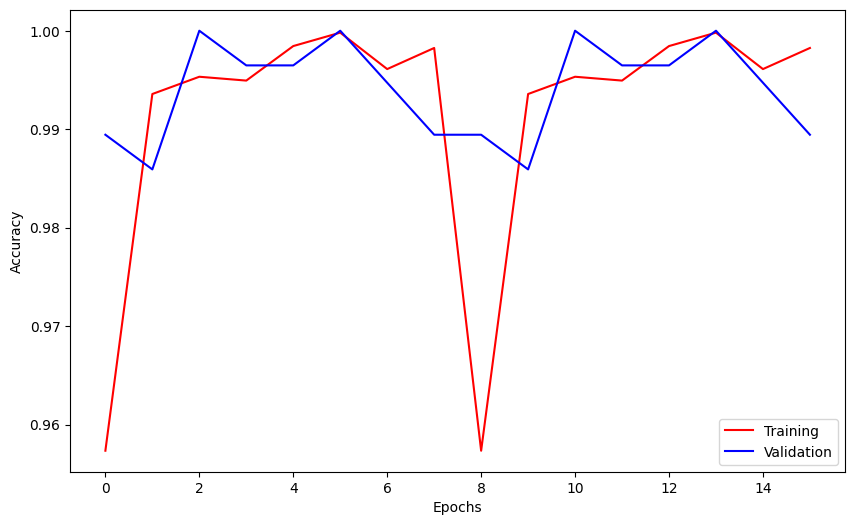

In [ ]:
acc = df.accuracy.values
val_acc =df.val_accuracy.values
epochs = range(len(acc))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

**4. Testing the model**

Load the best model

In [ ]:
filepath = work_directory+f'/output/transformer/best_model_{plant}.h5'

In [ ]:
vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = len(CATEGORIES))

In [ ]:
vit_model.compile

<bound method Model.compile of <keras.src.engine.functional.Functional object at 0x7c09aace5ba0>>

In [ ]:
best_model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(len(CATEGORIES), 'softmax')
    ],
    name = 'vision_transformer')

In [ ]:
from tensorflow import optimizers
opt = optimizers.Adam(learning_rate=0.0001)
best_model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
best_model.load_weights(filepath)

Get Test Loss

In [ ]:
best_model.evaluate(test_gen)

12/12 [==============================] - 27s 2s/step - loss: 2.0904e-04 - accuracy: 1.0000


[0.0002090391790261492, 1.0]

Get Predictions

In [ ]:
predictions = best_model.predict(test_gen)

12/12 [==============================] - 25s 2s/step


In [ ]:
pred_labels = np.argmax(predictions, axis=1)

In [ ]:
true_labels = test_gen.classes

In [ ]:
labels= list(train_gen.class_indices.keys())
labels

['Potato___Late_blight', 'Potato___healthy', 'Potato___Early_blight']

In [ ]:
labels = [l.split('___')[-1] for l in labels]
labels

['Late_blight', 'healthy', 'Early_blight']

Classification report

In [ ]:
report = classification_report(true_labels, pred_labels, target_names=labels, digits=4)
print(report)

              precision    recall  f1-score   support

 Late_blight     1.0000    1.0000    1.0000       485
     healthy     1.0000    1.0000    1.0000       456
Early_blight     1.0000    1.0000    1.0000       485

    accuracy                         1.0000      1426
   macro avg     1.0000    1.0000    1.0000      1426
weighted avg     1.0000    1.0000    1.0000      1426



Confusion Matrix

In [ ]:
cm = confusion_matrix(true_labels, pred_labels)

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()




Normalized confusion matrix
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


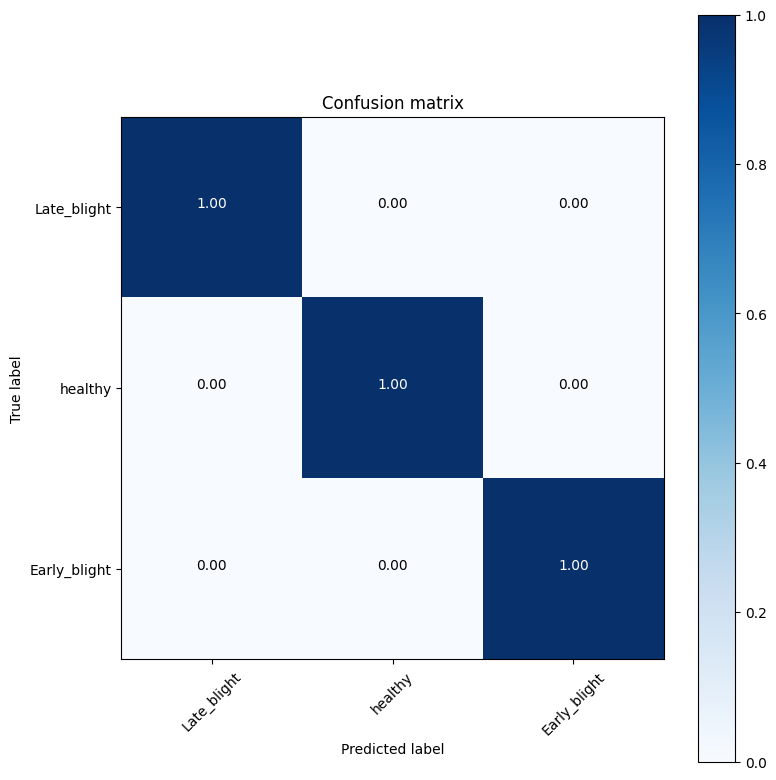

In [ ]:

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, classes=labels,normalize= True,  title='Confusion matrix')